# Auto time series forecaster example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Automatic time series forecasting 
import AutoTimeSeriesForecaster
# set style
plt.style.use('ggplot')
# warning filter
import warnings
warnings.filterwarnings('ignore')
# set random seed
np.random.seed(80)

In [2]:
# Creating a dataset of ED admissions (not using real data)
df_in = pd.DataFrame()
df_in.index = pd.date_range(start = '2021-01-01', end = '2023-04-10', freq='d')
# ED Admissions, random number between 30 and 50
df_in['ED Admissions'] = np.random.randint(low=30, high=50, size=len(df_in))
# ED Admissions 50% higher on weekends
df_in.loc[df_in.index.weekday.isin([5, 6]), 'ED Admissions'] *= 1.5
# ED Admissions 100% higher on New Years day
df_in.loc[df_in.index.dayofyear == 1, 'ED Admissions'] *= 2
# Ensure values are integers
df_in = df_in.astype('int')
# Display first 5 rows
df_in.head()

,ED Admissions
2021-01-01,90
2021-01-02,54
2021-01-03,73
2021-01-04,40
2021-01-05,48


In [3]:
# Instantiate instance of the AutoTS class.
AutoTS = AutoTimeSeriesForecaster.AutoTS(input_df = df_in, # Input dataframe
                           target = 'ED Admissions', # Target variable name
                           freq = 'd', # Frequency of data ('d' - Daily)
                           sp = 7, # sp - Seasonal Period
                           holidays_list = ["New Year's Day"] ) # Include effect of New Years day

# Carry out cross validation on training data
AutoTS.ts_cv(forecast_horizon = 14, # forecast 2 weeks each fold
             folds = 5, # Number of cross validation folds
             perf_metric='MAPE') # Performance metric to minimise when selecting chosen model

2023-04-13 15:20:58 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-04-13 15:20:59 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-04-13 15:20:59 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-04-13 15:21:00 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-04-13 15:21:01 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-04-13 15:21:01 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [4]:
# Print cross validation results (showing MAPE)
AutoTS.cv_summary

,MAPE,MSE,MAE
model,,,
Facebook Prophet,0.129886,45.551986,5.707271
ETS,0.133286,45.912071,5.806657
ARIMA,0.139571,50.859900,6.122829
STL,0.177857,88.600343,7.648686
Seasonal Naive,0.186457,94.542857,7.857143


In [5]:
# Produce forecasts (using default model i.e., lowest MAPE during cross validation.)
AutoTS.forecast(timesteps = 365, # forecast horizon
                pi = 0.95) # Prediction interval width (95%)

In [6]:
AutoTS.forecast_df.head()

,yhat,yhat_lower,yhat_upper
2023-04-11,37.769209,24.465323,50.454790
2023-04-12,37.786807,24.568309,51.138359
2023-04-13,37.908624,24.386985,50.665182
2023-04-14,38.338500,25.987839,51.233426
2023-04-15,58.040262,45.607966,71.442989


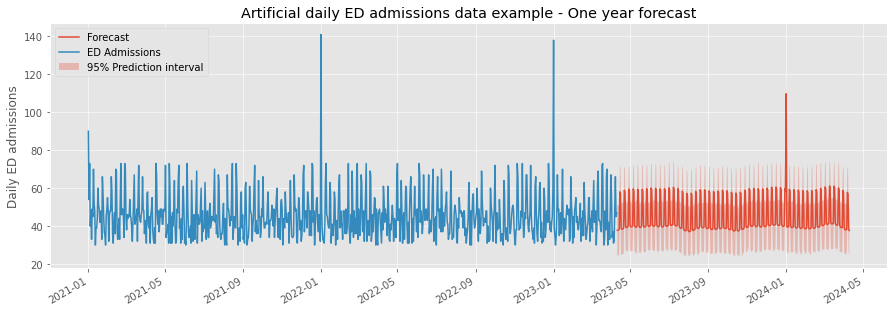

In [7]:
# Forecast plot
_, ax = plt.subplots(figsize = (20, 5))

prediction = AutoTS.forecast_df
ax.fill_between(x = prediction.index, y1 = prediction.yhat_lower, 
               y2 = prediction.yhat_upper, alpha = 0.3, label = '95% Prediction interval')
ax.plot(prediction.index, prediction.yhat, label = 'Forecast')
df_in[['ED Admissions']].plot(figsize = (15, 5), ax = ax)
ax.grid(alpha = 0.75)
ax.legend(loc='upper left')
ax.set_ylabel('Daily ED admissions')
ax.set_title('Artificial daily ED admissions data example - One year forecast')
plt.show()